# Delta Calculation Maps

In [1]:
import xarray as xr
import xoak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import geopandas as gpd
import regionmask
import cartopy
import cartopy.crs as ccrs
import glob
from copy import deepcopy

In [2]:
from matplotlib.colors import ListedColormap, BoundaryNorm


def div_colorbar():
    
    div_colors = ['#053061',
                  '#2166ac',
                  '#4393c3',
                  '#92c5de',
                  '#d1e5f0',
                  '#f7f7f7',
                  '#fddbc7',
                  '#f4a582',
                  '#d6604d',
                  '#b2182b',
                  '#67001f'
                  ]
    
    cmap = ListedColormap(div_colors)
    
    return cmap

def div_boundarynorm():
    
    
    cmap = div_colorbar()
    classes = np.array(list(np.linspace(-5, 5, num=11)))
    norm = BoundaryNorm(classes, ncolors=cmap.N) 
    
    return cmap, norm

cmap, norm = div_boundarynorm()

In [3]:
from matplotlib.colors import ListedColormap, BoundaryNorm


def div_colorbar():
    
    div_colors = ['#053061',
                  '#2166ac',
                  '#4393c3',
                  '#92c5de',
                  '#f7f7f7',
                  '#f4a582',
                  '#d6604d',
                  '#b2182b',
                  '#67001f'
                  ]
    
    cmap = ListedColormap(div_colors)
    
    return cmap

def div_boundarynorm():
    
    
    cmap = div_colorbar()
    classes = np.array(list(np.linspace(-3.5, 3.5, num=9)))
    norm = BoundaryNorm(classes, ncolors=cmap.N) 
    
    return cmap, norm

cmap, norm = div_boundarynorm()

### Load Data

In [4]:
#load wrf-bcc dataframes
df_HIST = pd.concat(map(pd.read_csv, glob.glob('/home/scratch/jcorner1/syn_sev/dataframes/HIST_UVV_[21]*_*')), ignore_index=True)
df_8p5END = pd.concat(map(pd.read_csv, glob.glob('/home/scratch/jcorner1/syn_sev/dataframes/EOC8p5_UVV*')), ignore_index=True)
df_4p5END = pd.concat(map(pd.read_csv, glob.glob('/home/scratch/jcorner1/syn_sev/dataframes/EOC4p5_UVV*')), ignore_index=True)
df_8p5MID = pd.concat(map(pd.read_csv, glob.glob('/home/scratch/jcorner1/syn_sev/dataframes/MC8p5_UVV*')), ignore_index=True)
df_4p5MID = pd.concat(map(pd.read_csv, glob.glob('/home/scratch/jcorner1/syn_sev/dataframes/MC4p5_UVV*')), ignore_index=True)

#iterate through the epochs and threshold each based on UVV value
epochs = ['HIST', '4p5MID', '8p5MID', '4p5END', '8p5END']

for epoch in epochs:
    locals()[f'df_{epoch}'] = locals()[f'df_{epoch}'][((locals()[f'df_{epoch}']['DBZ'] >= 40.0) & (locals()[f'df_{epoch}']['UVV'] >= 25.0))]
    locals()[f'df_{epoch}']['Time'] = pd.to_datetime( locals()[f'df_{epoch}']['Time'])
    locals()[f'df_{epoch}']['Month'] = pd.to_datetime( locals()[f'df_{epoch}']['Time']).dt.month

### Mode Days

In [5]:
seasons = ['DJF', 'MAM', 'JJA', 'SON']

#iterate through each epoch
for epoch in epochs:
    geog = xr.open_dataset("/home/scratch/WRF_BCC/geography/geo_em.d01.nc")
    print(epoch)
    df_wrf = locals()[f'df_{epoch}']
    
    for season in seasons:
        if season == 'DJF':
            df_seas = df_wrf[(df_wrf['Month'].isin([12,1,2]))]
        elif season == 'MAM':
            df_seas = df_wrf[(df_wrf['Month'].isin([3,4,5]))]
        elif season == 'JJA':
            df_seas = df_wrf[(df_wrf['Month'].isin([6,7,8]))]
        elif season == 'SON':
            df_seas = df_wrf[(df_wrf['Month'].isin([9,10,11]))]

        uhs = []    
        #iterate through each
        for did, day in df_seas.resample('24h', origin='1990-10-01 12:00:00', on='Time'):

            results = np.zeros(shape=(899, 1399))
            results[day.y.values.astype(int), day.x.values.astype(int)] = 1
            uh_uvv = deepcopy(geog)
            uh_uvv = uh_uvv.assign_coords({'Time': np.array([did])})
            uh_uvv = uh_uvv.assign(UVV_DAYS = (('Time', 'south_north', 'west_east'), np.expand_dims(results, axis=0)))
            uh_uvv = uh_uvv[['CLAT', 'CLONG', 'UVV_DAYS']].coarsen(south_north=20, west_east=20, boundary='trim').mean()
            uh_uvv['UVV_DAYS'] = 1*(uh_uvv['UVV_DAYS'] > 0)

            uhs.append(uh_uvv)

        locals()[f'uhs_{epoch}_{season}'] = xr.concat(uhs, dim='Time')

        if epoch != 'HIST':
            locals()[f'delta_{epoch}_{season}'] = (np.sum(locals()[f'uhs_{epoch}_{season}'].UVV_DAYS.values, axis=0) - np.sum(locals()[f'uhs_HIST_{season}'].UVV_DAYS.values, axis=0)) / 15

HIST
4p5MID
8p5MID
4p5END
8p5END


/tmp/ipykernel_64955/1726284074.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(4, 4, x, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))


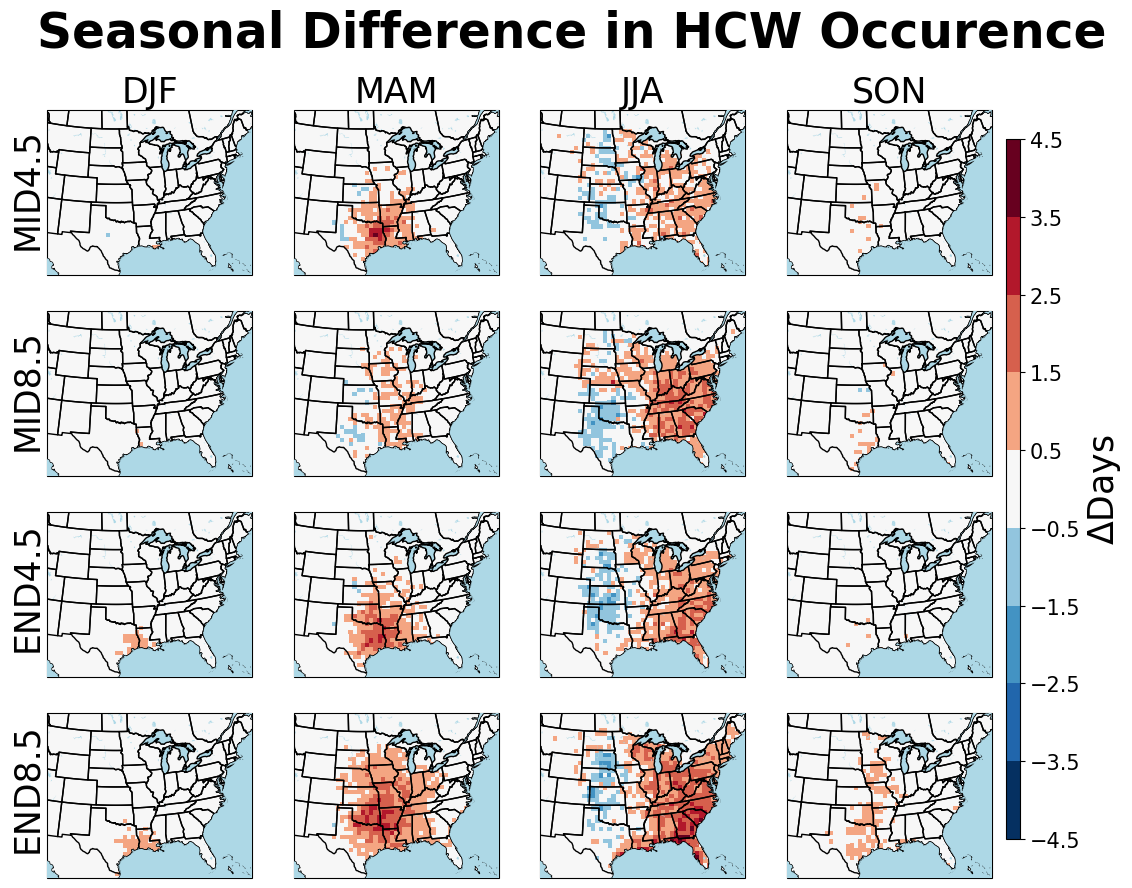

In [6]:
#Plot the data
fig = plt.figure(figsize=(14,10))
plt.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)

divnorm=colors.TwoSlopeNorm(vmin=-4.5, vcenter=0., vmax=4.5)
epoch_labels = ['MID4.5', 'MID8.5', 'END4.5', 'END8.5']

plt.subplots_adjust(right=0.8)
title = plt.suptitle('Seasonal Difference in HCW Occurence', size=35).set_weight('bold')
cbar_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])

x = 1

for i in range(len(epochs[1:])):
    for j in range(len(seasons)):

        ax = plt.subplot(4, 4, x, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))
        c = ax.pcolormesh(uhs_HIST_DJF.CLONG.values[0,:,:], uhs_HIST_DJF.CLAT.values[0,:,:],locals()[f'delta_{epochs[1:][i]}_{seasons[j]}'],
                          transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=divnorm)

        ax.add_feature(cartopy.feature.STATES, zorder=2)
        ax.add_feature(cartopy.feature.COASTLINE, zorder=3)
        ax.add_feature(cartopy.feature.LAND, facecolor='gray')
        ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue', zorder=3)
        ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')

        ax.set_extent([-110, -74, 24.5, 50])

        #ax.annotate(f'{epochs[1:][i]} - ', (0.05,0.05),fontsize=16, xycoords='axes fraction')
        
        if x <= 4:
            plt.title(f'{seasons[j]}',fontsize=25)
            
        if x in [1, 5, 9, 13]:
            #plt.ylabel(,fontsize=25)
            ax.annotate(f'{epoch_labels[i]}', xy=(-0.18,0.2), xycoords='axes fraction', fontsize=25, rotation='vertical')
        
        x=x+1
        
        
    
cbar = plt.colorbar(c,ticks=np.array(range(-5, 5, 1))+0.5, pad=0.01, ax=ax, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label='$\Delta$Days', size=25)
plt.savefig('../Plots/Seasonal_deltas.png', format='png', dpi=500, bbox_inches='tight')
plt.show()

### Percent Change

In [7]:
for epoch in epochs:
    for season in seasons:
        
        if epoch != 'HIST':
            locals()[f'pc_{season}_{epoch}'] = ((np.sum(locals()[f'uhs_{epoch}_{season}'].UVV_DAYS.values, axis=0) - np.sum(locals()[f'uhs_HIST_{season}'].UVV_DAYS.values, axis=0))
                                                 /np.sum(locals()[f'uhs_HIST_{season}'].UVV_DAYS.values, axis=0)) * 100

/tmp/ipykernel_64955/802369357.py:5: RuntimeWarning: divide by zero encountered in divide
  locals()[f'pc_{season}_{epoch}'] = ((np.sum(locals()[f'uhs_{epoch}_{season}'].UVV_DAYS.values, axis=0) - np.sum(locals()[f'uhs_HIST_{season}'].UVV_DAYS.values, axis=0))
/tmp/ipykernel_64955/802369357.py:5: RuntimeWarning: invalid value encountered in divide
  locals()[f'pc_{season}_{epoch}'] = ((np.sum(locals()[f'uhs_{epoch}_{season}'].UVV_DAYS.values, axis=0) - np.sum(locals()[f'uhs_HIST_{season}'].UVV_DAYS.values, axis=0))


/tmp/ipykernel_64955/3471251029.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(4, 4, x, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))


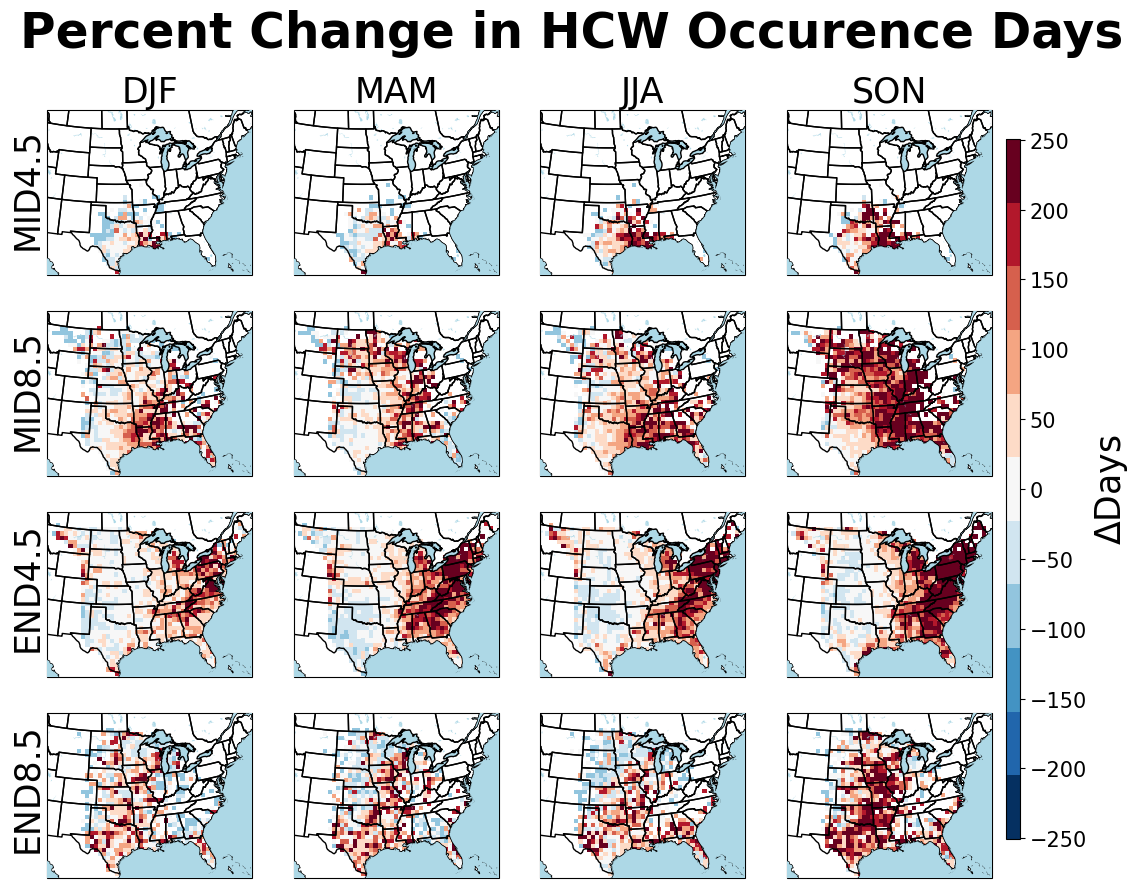

In [52]:
#Plot the data
fig = plt.figure(figsize=(14,10))
plt.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)

divnorm=colors.TwoSlopeNorm(vmin=-250.5, vcenter=0., vmax=250.5)
epoch_labels = ['MID4.5', 'MID8.5', 'END4.5', 'END8.5']

plt.subplots_adjust(right=0.8)
title = plt.suptitle('Percent Change in HCW Occurence Days', size=35).set_weight('bold')
cbar_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])

x = 1

for i in range(len(epochs[1:])):
    for j in range(len(seasons)):

        ax = plt.subplot(4, 4, x, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))
        c = ax.pcolormesh(uhs_HIST_DJF.CLONG.values[0,:,:], uhs_HIST_DJF.CLAT.values[0,:,:],locals()[f'pc_{seasons[i]}_{epochs[1:][j]}'],
                          transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=divnorm)

        ax.add_feature(cartopy.feature.STATES, zorder=2)
        ax.add_feature(cartopy.feature.COASTLINE, zorder=3)
        ax.add_feature(cartopy.feature.LAND, facecolor='white')
        ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue', zorder=3)
        ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')

        ax.set_extent([-110, -74, 24.5, 50])

        #ax.annotate(f'{epochs[1:][i]} - ', (0.05,0.05),fontsize=16, xycoords='axes fraction')
        
        if x <= 4:
            plt.title(f'{seasons[j]}',fontsize=25)
            
        if x in [1, 5, 9, 13]:
            #plt.ylabel(,fontsize=25)
            ax.annotate(f'{epoch_labels[i]}', xy=(-0.18,0.2), xycoords='axes fraction', fontsize=25, rotation='vertical')
        
        x=x+1
        
        
    
cbar = plt.colorbar(c,ticks=np.array(range(-250, 251, 50)), pad=0.01, ax=ax, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label='$\Delta$Days', size=25)
plt.savefig('../Plots/Seasonal_pc.png', format='png', dpi=500, bbox_inches='tight')
plt.show()

### Mode Counts

In [50]:
def Data_Conv(ds):
    
    '''
    A defintion  
    
    Parameters
    ----------
    ds: xarray dataset
    
    Returns
    -------
    ds_mask: a masked xarray dataset
    
    '''
    geog = xr.open_dataset("/home/scratch/WRF_BCC/geography/geo_em.d01.nc")
    geog = geog[['CLAT', 'CLONG']].coarsen(south_north=20, west_east=20, boundary='trim').mean()
    
    ds = ds.coarsen(south_north=20, west_east=20, boundary='trim').sum()
    ds = xr.merge([ds, geog.squeeze()])
    ds = ds.rename({"CLONG": 'lon', 'CLAT': 'lat'})

    ds = ds.assign_coords({'x': ds.west_east, 'y': ds.south_north})
    ds = ds.assign_coords({'lon': ds.lon, 'lat': ds.lat})
    ds.xoak.set_index(['lat', 'lon'], 'sklearn_geo_balltree')
    
    #mask out area 
    ds_mask = mask_data(ds)
    
    
    return ds_mask

In [48]:
def convert_xy_to_latlon(points_in):

    geog = xr.open_dataset("/home/scratch/WRF_BCC/geography/geo_em.d01.nc")

    lons = geog.CLONG.values[0,:,:]
    lats = geog.CLAT.values[0,:,:]
        
    points_in['lon'] = [lons[int(y), int(x)] for y, x in zip(points_in['y'], points_in['x'])]
    points_in['lat'] = [lats[int(y), int(x)] for y, x in zip(points_in['y'], points_in['x'])]

    gpd_points = gpd.GeoDataFrame(points_in, geometry=gpd.points_from_xy(points_in.lon, points_in.lat))

    gpd_points = gpd_points.set_crs('epsg:4269')
    
    return gpd_points

In [30]:
def mask_data(in_data):
    
    '''
    A defintion masking data in the US, east of the Rockies. 
    
    Parameters
    ----------
    in_data: xarray dataset
    
    Returns
    -------
    out_data: a masked xarray dataset
    
    '''
    
    usa = gpd.read_file("/home/jcorner1/Unidata/shapefiles/smoothing_econus.shp")

    state_mask = regionmask.mask_geopandas(usa, in_data.lon, in_data.lat)
    ma = state_mask.values
    ma[~np.isnan(ma)] = 1

    out_data = in_data * ma
    
    return out_data

In [31]:
from matplotlib.colors import ListedColormap, BoundaryNorm

def div_colorbar():
    
    div_colors = ['#053061',
                  '#2166ac',
                  '#4393c3',
                  '#92c5de',
                  '#d1e5f0',
                  '#f7f7f7',
                  '#fddbc7',
                  '#f4a582',
                  '#d6604d',
                  '#b2182b',
                  '#67001f'
                  ]
    
    cmap = ListedColormap(div_colors)
    
    return cmap

def div_boundarynorm():
    
    
    cmap = div_colorbar()
    classes = np.array(list(np.linspace(-22.5, 22.5, num=10)))
    norm = BoundaryNorm(classes, ncolors=cmap.N) 
    
    return cmap, norm

cmap, norm = div_boundarynorm()

In [33]:
#open simple nc file to copy to
ds = xr.open_dataset('/home/scratch/WRF_BCC/reflectivity/REFD/historical/1990-1991/REFD_historical-1990-1991_1990-10-01.nc')
ds = ds.sel(Time ='1990-10-01T00:00:00.000000000')
ds_copy = ds.copy()
ds_copy

<xarray.Dataset>
Dimensions:  (south_north: 899, west_east: 1399)
Coordinates:
    Time     datetime64[ns] 1990-10-01
Dimensions without coordinates: south_north, west_east
Data variables:
    REFD     (south_north, west_east) float32 ...
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      1990-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2
    history:                         Tue Sep  8 08:07:31 2020: ncks -O -x -v ...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...

In [ ]:
#create lists for the epochs and seasons
types = ['hist', 'eoc4p5', 'eoc8p5']
seasons = ['Winter', 'Spring', 'Summer', 'Fall']

#interate through the epochs
for epoch in types:
    csvs = []

    #find all CSVs with convective modes
    for csv in glob.glob(f"/home/scratch/jcorner1/Thesis/data/storm_mode/storm_modes_*_{epoch}.csv"):
        
        #
        svr_pts = pd.read_csv(csv, parse_dates=['Time'])
        svr_pts = convert_xy_to_latlon(svr_pts)
        csvs.append(svr_pts)

    #append the csvs together
    csvs = pd.concat(csvs, ignore_index=True)
    
    #seperate timing values into their own column
    csvs['Year'] = pd.to_datetime(csvs['Time']).dt.year
    csvs['Month'] = pd.to_datetime(csvs['Time']).dt.month
    csvs['Day'] = pd.to_datetime(csvs['Time']).dt.day
    csvs['Hour'] = pd.to_datetime(csvs['Time']).dt.time
    
    #iterate through the seasons
    for season in seasons:
        if season == 'Winter':
            locals()[f"csvs_{epoch}_{season}"] = csvs[((csvs['Month'] <= 2) | (csvs['Month'] == 12))]
            
        elif season == 'Spring':
            locals()[f"csvs_{epoch}_{season}"] = csvs[((csvs['Month'] >=3 ) & (csvs['Month'] <= 5))]
            
        elif season == 'Summer':
            locals()[f"csvs_{epoch}_{season}"] = csvs[((csvs['Month'] >=6 ) & (csvs['Month'] <= 8))]
            
        elif season == 'Fall':
            locals()[f"csvs_{epoch}_{season}"] = csvs[((csvs['Month'] >=9 ) & (csvs['Month'] <= 11))]
            
        

In [62]:
for epoch in epochs:
    
    for season in seasons:
        csvs = locals()[f"df_{epoch}"].copy()
        
        #seperate timing values into their own column
        csvs['Year'] = pd.to_datetime(csvs['Time']).dt.year
        csvs['Month'] = pd.to_datetime(csvs['Time']).dt.month
        csvs['Day'] = pd.to_datetime(csvs['Time']).dt.day
        csvs['Hour'] = pd.to_datetime(csvs['Time']).dt.time
        
        if season == 'DJF':
            locals()[f"csvs_{epoch}_{season}"] = csvs[((csvs['Month'] <= 2) | (csvs['Month'] == 12))]
            
        elif season == 'MAM':
            locals()[f"csvs_{epoch}_{season}"] = csvs[((csvs['Month'] >=3 ) & (csvs['Month'] <= 5))]
            
        elif season == 'JJA':
            locals()[f"csvs_{epoch}_{season}"] = csvs[((csvs['Month'] >=6 ) & (csvs['Month'] <= 8))]
            
        elif season == 'SON':
            locals()[f"csvs_{epoch}_{season}"] = csvs[((csvs['Month'] >=9 ) & (csvs['Month'] <= 11))]
            
        print(epoch, season, len(locals()[f"csvs_{epoch}_{season}"]))
        
        locals()[f'{epoch}_blanks_{season}'] = np.zeros((899,1399))
        
        for rid, row in locals()[f"csvs_{epoch}_{season}"].iterrows():
            locals()[f'{epoch}_blanks_{season}'][row['y'], row['x']] = locals()[f'{epoch}_blanks_{season}'][row['y'], row['x']] + 1
    
        if epoch != "HIST":
            locals()[f'{epoch}_{season}_deltas'] = (locals()[f'{epoch}_blanks_{season}']/15) - (locals()[f'HIST_blanks_{season}']/15)

            locals()[f'ds_{epoch}_{season}'] = ds_copy.assign(UP_HELI_MAX = (('south_north', 'west_east'), locals()[f'{epoch}_{season}_deltas']))
            locals()[f'ds_cov_{epoch}_{season}'] =  Data_Conv(locals()[f'ds_{epoch}_{season}'])

            #locals()[f'{epoch}_{season}_pc'] = (((locals()[f'{epoch}_blanks_{season}']/15) - (locals()[f'HIST_blanks_{season}']/15))/(locals()[f'HIST_blanks_{season}']/15))*100
            locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100


            locals()[f'ds_{epoch}_{season}pc'] = ds_copy.assign(UP_HELI_MAX = (('south_north', 'west_east'), locals()[f'{epoch}_{season}_pc']))
            locals()[f'ds_cov_{epoch}_{season}pc'] =  Data_Conv(locals()[f'ds_{epoch}_{season}pc'])


HIST DJF 3387
HIST MAM 37121
HIST JJA 104332
HIST SON 7639
4p5MID DJF 4109


/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100
/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100


4p5MID MAM 62847


/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100
/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100


4p5MID JJA 117467


/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100
/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100


4p5MID SON 9375


/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100
/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100


8p5MID DJF 3355


/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100
/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100


8p5MID MAM 50868


/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100
/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100


8p5MID JJA 138073


/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100
/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100


8p5MID SON 10542


/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100
/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100


4p5END DJF 5746


/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100
/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100


4p5END MAM 76185


/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100
/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100


4p5END JJA 122281


/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100
/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100


4p5END SON 8944


/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100
/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100


8p5END DJF 8074


/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100
/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100


8p5END MAM 102641


/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100
/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100


8p5END JJA 157412


/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100
/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100


8p5END SON 18365


/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100
/tmp/ipykernel_64955/1046400041.py:38: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_pc'] = ((locals()[f'{epoch}_blanks_{season}'] - locals()[f'HIST_blanks_{season}'])/locals()[f'HIST_blanks_{season}'])*100


In [59]:
(((locals()[f'{epoch}_blanks_{season}']/15) - (locals()[f'HIST_blanks_{season}']/15))/(locals()[f'HIST_blanks_{season}']/15))*100

/tmp/ipykernel_64955/2187517079.py:1: RuntimeWarning: divide by zero encountered in divide
  (((locals()[f'{epoch}_blanks_{season}']/15) - (locals()[f'HIST_blanks_{season}']/15))/(locals()[f'HIST_blanks_{season}']/15))*100
/tmp/ipykernel_64955/2187517079.py:1: RuntimeWarning: invalid value encountered in divide
  (((locals()[f'{epoch}_blanks_{season}']/15) - (locals()[f'HIST_blanks_{season}']/15))/(locals()[f'HIST_blanks_{season}']/15))*100


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

/tmp/ipykernel_64955/3850756190.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(4, 4, x, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))


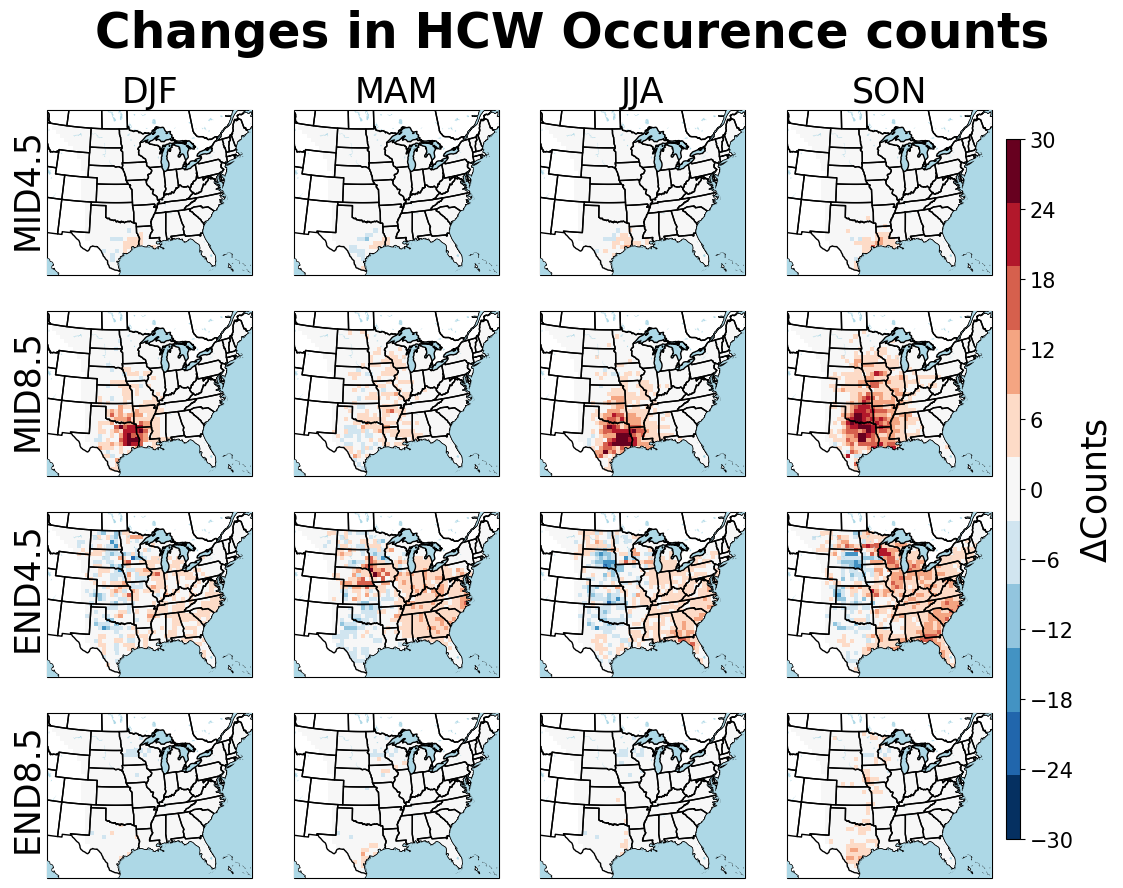

In [57]:
#Plot the data
fig = plt.figure(figsize=(14,10))
plt.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)

divnorm=colors.TwoSlopeNorm(vmin=-30, vcenter=0., vmax=30)
epoch_labels = ['MID4.5', 'MID8.5', 'END4.5', 'END8.5']

plt.subplots_adjust(right=0.8)
title = plt.suptitle('Changes in HCW Occurence counts', size=35).set_weight('bold')
cbar_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])

x = 1

for i in range(len(epochs[1:])):
    for j in range(len(seasons)):

        ax = plt.subplot(4, 4, x, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))
        c = ax.pcolormesh(uhs_HIST_DJF.CLONG.values[0,:,:], uhs_HIST_DJF.CLAT.values[0,:,:]
                          ,locals()[f'ds_cov_{epochs[1:][j]}_{seasons[i]}'].UP_HELI_MAX.values,
                          transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=divnorm)

        ax.add_feature(cartopy.feature.STATES, zorder=2)
        ax.add_feature(cartopy.feature.COASTLINE, zorder=3)
        ax.add_feature(cartopy.feature.LAND, facecolor='white')
        ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue', zorder=3)
        ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')

        ax.set_extent([-110, -74, 24.5, 50])

        #ax.annotate(f'{epochs[1:][i]} - ', (0.05,0.05),fontsize=16, xycoords='axes fraction')
        
        if x <= 4:
            plt.title(f'{seasons[j]}',fontsize=25)
            
        if x in [1, 5, 9, 13]:
            #plt.ylabel(,fontsize=25)
            ax.annotate(f'{epoch_labels[i]}', xy=(-0.18,0.2), xycoords='axes fraction', fontsize=25, rotation='vertical')
        
        x=x+1
        
        
    
cbar = plt.colorbar(c,ticks=np.array(range(-30, 31, 6)), pad=0.01, ax=ax, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label='$\Delta$Counts', size=25)
plt.savefig('../Plots/Seasonal_counts.png', format='png', dpi=500, bbox_inches='tight')
plt.show()

/tmp/ipykernel_64955/1979829556.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(4, 4, x, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))


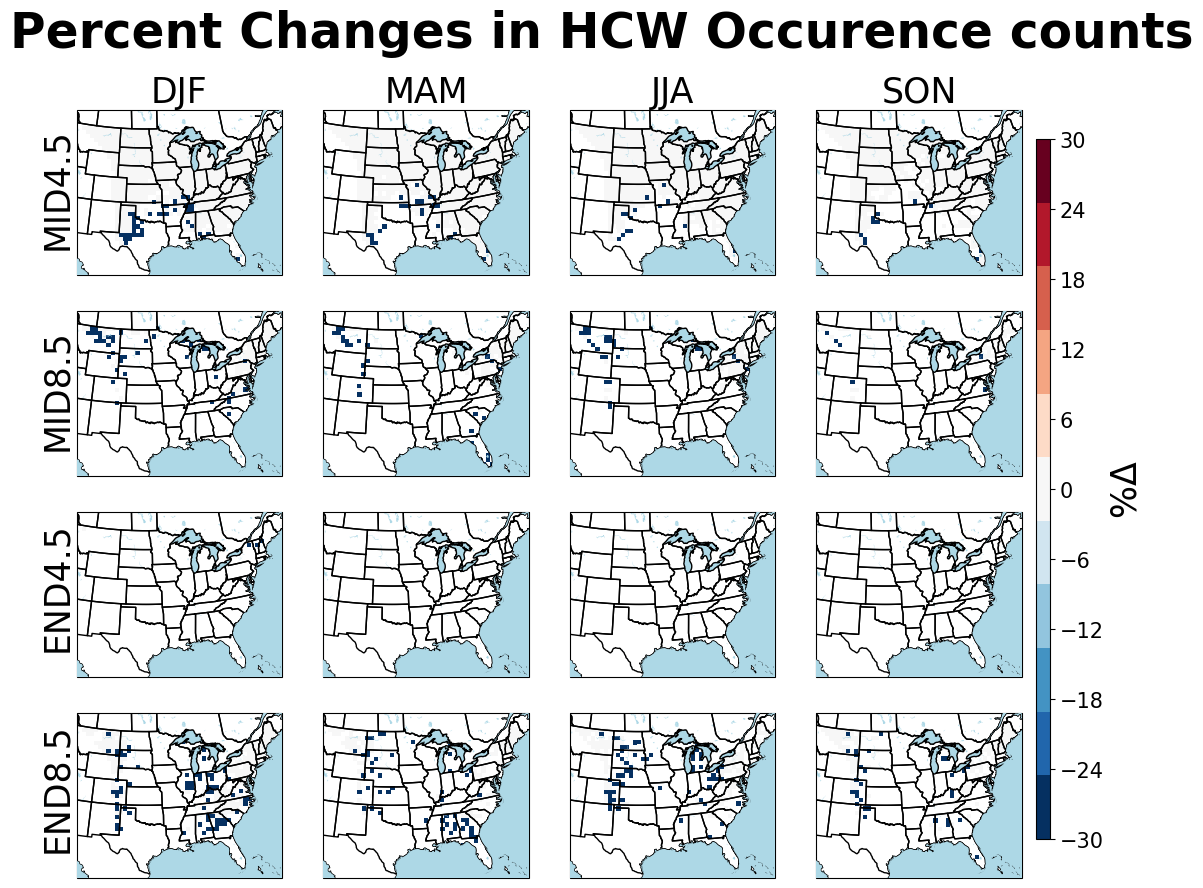

In [63]:
#Plot the data
fig = plt.figure(figsize=(14,10))
plt.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)

divnorm=colors.TwoSlopeNorm(vmin=-30, vcenter=0., vmax=30)
epoch_labels = ['MID4.5', 'MID8.5', 'END4.5', 'END8.5']

plt.subplots_adjust(right=0.8)
title = plt.suptitle('Percent Changes in HCW Occurence counts', size=35).set_weight('bold')
cbar_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])

x = 1

for i in range(len(epochs[1:])):
    for j in range(len(seasons)):

        ax = plt.subplot(4, 4, x, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))
        c = ax.pcolormesh(uhs_HIST_DJF.CLONG.values[0,:,:], uhs_HIST_DJF.CLAT.values[0,:,:]
                          ,locals()[f'ds_cov_{epochs[1:][j]}_{seasons[i]}pc'].UP_HELI_MAX.values,
                          transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=divnorm)

        ax.add_feature(cartopy.feature.STATES, zorder=2)
        ax.add_feature(cartopy.feature.COASTLINE, zorder=3)
        ax.add_feature(cartopy.feature.LAND, facecolor='white')
        ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue', zorder=3)
        ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')

        ax.set_extent([-110, -74, 24.5, 50])

        #ax.annotate(f'{epochs[1:][i]} - ', (0.05,0.05),fontsize=16, xycoords='axes fraction')
        
        if x <= 4:
            plt.title(f'{seasons[j]}',fontsize=25)
            
        if x in [1, 5, 9, 13]:
            #plt.ylabel(,fontsize=25)
            ax.annotate(f'{epoch_labels[i]}', xy=(-0.18,0.2), xycoords='axes fraction', fontsize=25, rotation='vertical')
        
        x=x+1
        
        
    
cbar = plt.colorbar(c,ticks=np.array(range(-30, 31, 6)), pad=0.01, ax=ax, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label='%$\Delta$', size=25)
plt.savefig('../Plots/Seasonal_counts_pc.png', format='png', dpi=500, bbox_inches='tight')
plt.show()